In [1]:
from datetime import date
print(date.today())

2020-04-19


Traditionally there’s been a tradeoff between interpretability and performance. Classical machine learning methods such as linear and logistic regression make it easy to understand why a certain value was classified, however, assumptions of regression models limit the performance potential of these linear models. To improve accuracy, complex models may use hundreds, in some cases, thousands, trees and then combine their results . The financial industry is heavily regulated, and practitioners are obligated to explain why their model made a prediction, and that threshold has limited the types of models that can be implemented. This week I’m going to focus on understanding what’s driving each prediction for the Machine learning algorithms using SHAP (Shapley Additive Explanations).

SHAP was introduced at 31st Conference on Neural Information Processing Systems (NIPS 2017) and is a technique used in game theory to determine how much each player in a collaborative game has contributed to its success. In this models, each SHAP value measures how much each feature in our model contributes, either positively or negatively, to a customer’s default risk score.

SHAP value is useful in understanding the variables that impact the model’s decision; however, model interpretability can suffer if the features are correlated, and the model doesn’t provide the ability to estimate the impact of change in variables. In this section, I will interpret the SHAP values for a Random Forest,and AdaBoost

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [3]:
def normalized(data): 
    """
    Calculates the z score between two data sets
    """
    mean = data.mean()
    sd = data.std()
    score = (data - mean) / sd
    return score 

def column_scaler(data, column_skip): 
    """ 
    Scales each column in the dataset 
    """
    new_data = pd.DataFrame()
    
    for value in data.columns: 
        if value in column_skip: 
            new_data[value] = data[value]
        else: 
            column_data = data[value]
            new_data[value] = normalized(column_data)
    return new_data

In [4]:
df = pd.read_csv('data/XYZloan_default_selected_vars.zip')
df = df.drop(columns = ['Unnamed: 0','Unnamed: 0.1'])
df.head(3)

,id,loan_default,AP001,AP002,AP003,AP004,AP005,AP006,AP007,AP008,...,CD162,CD164,CD166,CD167,CD169,CD170,CD172,CD173,MB005,MB007
0,1,1,31,2,1,12,2017/7/6 10:21,ios,3,3,...,13.0,13.0,0.0,0.0,1449.0,1449.0,2249.0,2249.0,7.0,IPHONE7
1,2,0,27,1,1,12,2017/4/6 12:51,h5,5,4,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,NaN,WEB
2,3,0,33,1,4,12,2017/7/1 14:11,h5,4,2,...,3.0,2.0,33.0,0.0,33.0,0.0,143.0,110.0,8.0,WEB


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 87 columns):
id              80000 non-null int64
loan_default    80000 non-null int64
AP001           80000 non-null int64
AP002           80000 non-null int64
AP003           80000 non-null int64
AP004           80000 non-null int64
AP005           80000 non-null object
AP006           80000 non-null object
AP007           80000 non-null int64
AP008           80000 non-null int64
AP009           80000 non-null int64
TD001           80000 non-null int64
TD002           80000 non-null int64
TD005           80000 non-null int64
TD006           80000 non-null int64
TD009           80000 non-null int64
TD010           80000 non-null int64
TD013           80000 non-null int64
TD014           80000 non-null int64
TD015           80000 non-null int64
TD022           60402 non-null float64
TD023           72337 non-null float64
TD024           76306 non-null float64
TD025           77450 non-null f

In [6]:
# look for duplicates in id

len(df.id.unique()) == df.shape[0]

True

In [7]:
print(f'The total missing rate in the data set is {round(sum(df.isna().sum())*100 / (df.shape[0]*df.shape[1]), 2)} %')
print(f'The total null rate in the data set is {round(sum(df.isnull().sum())*100 / (df.shape[0]*df.shape[1]), 2)} %')

The total missing rate in the data set is 8.89 %
The total null rate in the data set is 8.89 %


In [8]:
df.isna().sum()

id                  0
loan_default        0
AP001               0
AP002               0
AP003               0
AP004               0
AP005               0
AP006               0
AP007               0
AP008               0
AP009               0
TD001               0
TD002               0
TD005               0
TD006               0
TD009               0
TD010               0
TD013               0
TD014               0
TD015               0
TD022           19598
TD023            7663
TD024            3694
TD025            2550
TD026            1846
TD027            1697
TD028            1636
TD029            1630
TD044           79997
TD048           79999
                ...  
CD107             381
CD108             381
CD113             381
CD114             381
CD115             381
CD117             381
CD118             381
CD120             381
CD121             381
CD123             381
CD130             381
CD131             381
CD132             381
CD133             381
CD135     

In [9]:
# computing the missing rate for each col:
for i in df.columns:
    miss_rate = (df[i].isna().sum() / df.shape[0]) * 100
    if miss_rate > 0: 
        print(f"The missing rate of {i} is : {miss_rate} %")

The missing rate of TD022 is : 24.4975 %
The missing rate of TD023 is : 9.57875 %
The missing rate of TD024 is : 4.6175 %
The missing rate of TD025 is : 3.1875 %
The missing rate of TD026 is : 2.3074999999999997 %
The missing rate of TD027 is : 2.12125 %
The missing rate of TD028 is : 2.045 %
The missing rate of TD029 is : 2.0375 %
The missing rate of TD044 is : 99.99625 %
The missing rate of TD048 is : 99.99875 %
The missing rate of TD051 is : 99.99375 %
The missing rate of TD054 is : 99.985 %
The missing rate of TD055 is : 99.99875 %
The missing rate of TD061 is : 99.9875 %
The missing rate of TD062 is : 99.99875 %
The missing rate of PA022 is : 0.47625 %
The missing rate of PA023 is : 0.47625 %
The missing rate of PA028 is : 0.47625 %
The missing rate of PA029 is : 0.47625 %
The missing rate of PA030 is : 0.47625 %
The missing rate of PA031 is : 0.47625 %
The missing rate of CD008 is : 0.47625 %
The missing rate of CD018 is : 0.47625 %
The missing rate of CD071 is : 0.47625 %
The mi



The number of missing values represents a small percentage of the dataset. However, those values shouldn’t be ignored. There are a number of different strategies to deal with missing values.

1. Imputation
2. Deletion

Exploring the colums with missing data will allow us to determine the best strategy to solve the missing data problem.


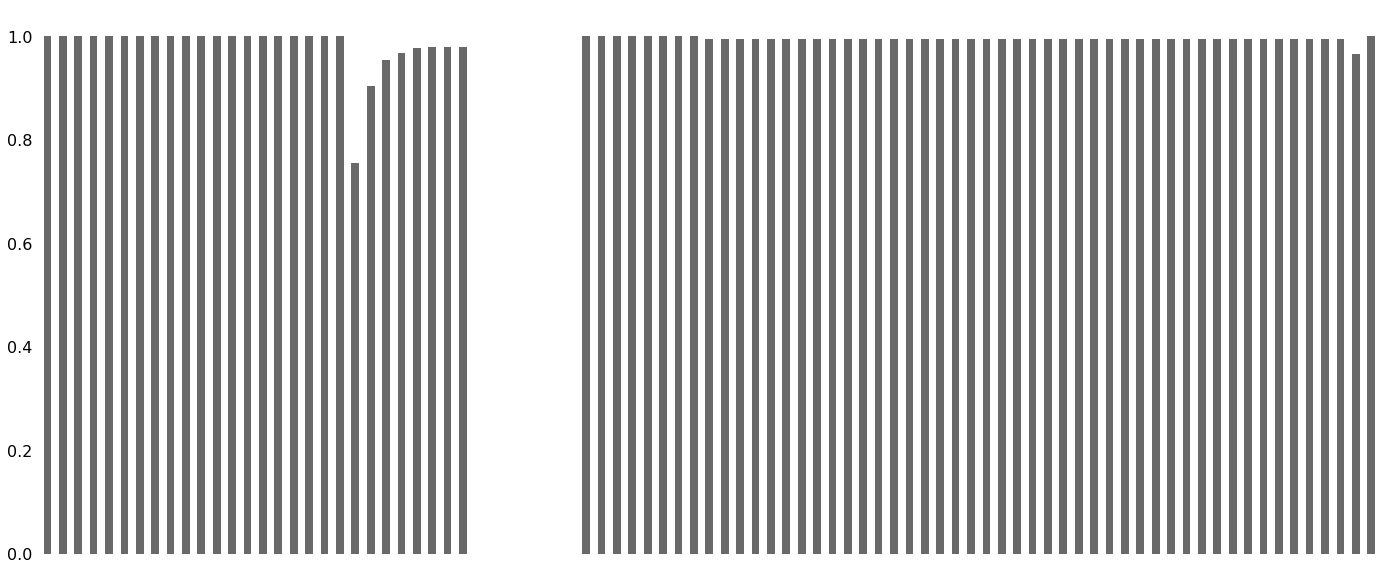

In [10]:
import missingno as ms 
fig = plt.figure(figsize= (5,5))
ms.bar(df)
plt.show()

As one can see some of the columns are missing all most all (> 90%). For those I will drop them 

In [11]:
col_missing = round((df.isna().sum() / df.shape[0]) * 100,2)

drop_col = col_missing[col_missing > 90].index
df = df.drop(drop_col, axis = 1)

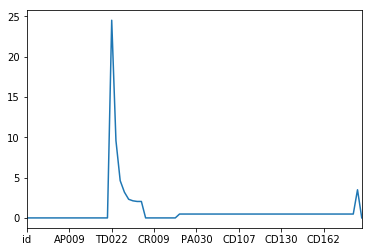

In [12]:
# check again see how the plot changed, this time i do mannually 

col_missing = round((df.isna().sum() / df.shape[0]) * 100,2)
col_missing.plot()



A few users represent the missing values in the data; after further analysis, it seems that missing patterns exist from a distinct group of users. The columns that have missing values also follow a pattern; they are all related to the phone. There are several reasons why that column could be missing: but the most likely reason is that those people don’t have a phone number, or it was never provided to the company.

The best option is to either remove them from the data or impute with 0. If we exclude from the data, a small but essential segment of our population could be misrepresented; on the contrary, if we include it could potentially skew the analysis since we assumed the missing values.

However, inputting the values with 0 makes the most sense for this data since, given that the users do not have a phone, the bank would be unable to call, leave voicemails and converse with the client, which is fair.


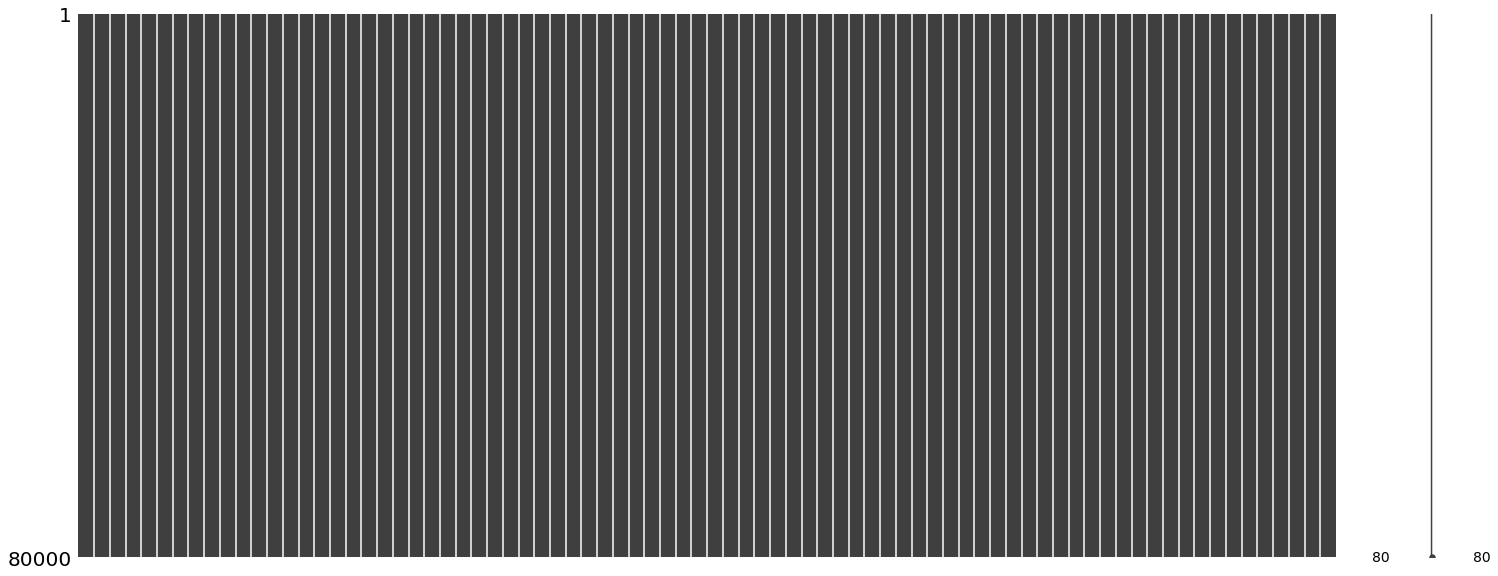

In [13]:
df = df.fillna(0)

# for the last time check the missing rate
ms.matrix(df)

In [14]:
df.describe() # for numerical columns CD166 	CD167 	CD169 	CD170 	CD172 	CD173 may skew the data since they are exteremly large compare to the others: may consider normalizing

,id,loan_default,AP001,AP002,AP003,AP004,AP007,AP008,AP009,TD001,...,CD160,CD162,CD164,CD166,CD167,CD169,CD170,CD172,CD173,MB005
count,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.00000,80000.000000,80000.000000,80000.000000,...,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000
mean,40000.500000,0.193600,31.706913,1.321813,2.014925,11.235413,3.30130,3.117200,0.727925,1.986962,...,6.879037,14.203725,11.717287,904.759775,806.924850,1724.441362,1532.003350,2501.257250,2218.987637,5.767625
std,23094.155105,0.395121,7.075070,0.467174,1.196806,2.212313,1.33655,1.306335,0.445031,1.807445,...,27.944778,38.156508,33.201216,1377.686717,1243.329932,2438.602116,2170.123099,3401.261179,3002.375858,3.742082
min,1.000000,0.000000,20.000000,1.000000,1.000000,3.000000,1.00000,1.000000,0.000000,0.000000,...,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,0.000000
25%,20000.750000,0.000000,27.000000,1.000000,1.000000,12.000000,2.00000,2.000000,0.000000,1.000000,...,2.000000,5.000000,4.000000,80.000000,28.000000,300.000000,219.000000,528.000000,404.000000,3.000000
50%,40000.500000,0.000000,30.000000,1.000000,1.000000,12.000000,3.00000,3.000000,1.000000,2.000000,...,7.000000,12.000000,10.000000,470.000000,393.000000,1014.000000,863.000000,1540.000000,1313.000000,5.000000
75%,60000.250000,0.000000,35.000000,2.000000,3.000000,12.000000,5.00000,4.000000,1.000000,3.000000,...,14.000000,23.000000,20.000000,1204.000000,1075.000000,2278.000000,2023.000000,3284.000000,2925.000000,8.000000
max,80000.000000,1.000000,56.000000,2.000000,6.000000,12.000000,5.00000,5.000000,1.000000,20.000000,...,1061.000000,2792.000000,1579.000000,48585.000000,29664.000000,88364.000000,54651.000000,125352.000000,87312.000000,47.000000


In [15]:
obj_col = df.loc[:, df.dtypes == object]

for c in obj_col:
    print(c, len(df[c].unique()))

AP005 55057
AP006 4
MB007 112


In [16]:
df.loc[:,'AP005'].head(3) # need to convert to datetime 

0    2017/7/6 10:21
1    2017/4/6 12:51
2    2017/7/1 14:11
Name: AP005, dtype: object

In [17]:
df.loc[:,'AP006'].head(3)

0    ios
1     h5
2     h5
Name: AP006, dtype: object

In [18]:
df.loc[:,'MB007'].head(3)

0    IPHONE7
1        WEB
2        WEB
Name: MB007, dtype: object

In [19]:
mb007_tab = df.MB007.value_counts().reset_index(name='count')
mb007_tab['cumsum(%)'] = round(mb007_tab['count'] *100 / mb007_tab['count'].sum(),2)
mb007_tab

,index,count,cumsum(%)
0,WEB,43850,54.81
1,IPHONE7,6335,7.92
2,IPHONE8,5186,6.48
3,OPPO,4313,5.39
4,IPHONE9,4237,5.30
5,VIVO,3673,4.59
6,HUAWEI,2458,3.07
7,Noinfo,2055,2.57
8,SAMSUNG,1646,2.06
9,XIAOMI,1470,1.84


The MB007 column contains many categorical values. I discovered that the top 10 features contribute to over 90% of the distribution. I gave the other categories the value of 'Other'.

In [20]:
df['MB007'] = df['MB007'].apply(lambda x: x if x in mb007_tab['index'][:10].tolist() else 'others')
df.MB007.value_counts()

WEB        43850
IPHONE7     6335
IPHONE8     5186
others      4777
OPPO        4313
IPHONE9     4237
VIVO        3673
HUAWEI      2458
Noinfo      2055
SAMSUNG     1646
XIAOMI      1470
Name: MB007, dtype: int64

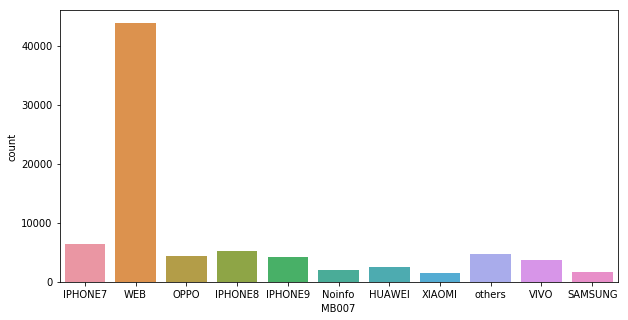

In [21]:
plt.figure(figsize=(10,5))
sns.countplot(x='MB007', data=df)



Since the values in column MBOO7 and AP006 are not ordinal, to prevent the model from assigning a higher value to the categorical data. I will One hot encode the variables


In [22]:
mb007_dum_col = list(pd.get_dummies(df['MB007']).columns)
ap006_dum_col = list(pd.get_dummies(df['AP006']).columns)
col_skip= mb007_dum_col + ap006_dum_col
col_skip

['HUAWEI',
 'IPHONE7',
 'IPHONE8',
 'IPHONE9',
 'Noinfo',
 'OPPO',
 'SAMSUNG',
 'VIVO',
 'WEB',
 'XIAOMI',
 'others',
 'android',
 'api',
 'h5',
 'ios']

In [23]:
df = pd.concat([df.reset_index(drop=True), pd.get_dummies(df.MB007)], axis=1)
df = pd.concat([df.reset_index(drop=True), pd.get_dummies(df.AP006)], axis=1)
df = df.drop(columns=['MB007','AP006'])

In [24]:
date_time = df['AP005'].str.split(' ',expand=True)# expand =True will make seperate columns for date and time
date_time.columns =['date', 'time']
col_skip = col_skip + list(date_time.columns)

After searching throughout the entire model for abnormalities, I found that the are numerous -99 value, which is another form of Null recorded. A small number of users have a considerable proportion of 99 values in their records. Those users can skew the model results, and I remove them.

In [25]:
list_99 = []

for r in range(len(df)):
    temp= df.iloc[r]
    list_99.append(list(temp).count(-99))

df_99= pd.DataFrame({'id': df.iloc[:,0], '99_count' : list_99})
df_99[df_99['99_count'] > 0]['99_count'].value_counts()

36    1773
42    1534
Name: 99_count, dtype: int64

In [26]:
del_id = df_99[df_99['99_count'] > 0]['id'].values
df = df[~df.iloc[:,0].isin(del_id)].reset_index()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76693 entries, 0 to 76692
Data columns (total 94 columns):
index           76693 non-null int64
id              76693 non-null int64
loan_default    76693 non-null int64
AP001           76693 non-null int64
AP002           76693 non-null int64
AP003           76693 non-null int64
AP004           76693 non-null int64
AP005           76693 non-null object
AP007           76693 non-null int64
AP008           76693 non-null int64
AP009           76693 non-null int64
TD001           76693 non-null int64
TD002           76693 non-null int64
TD005           76693 non-null int64
TD006           76693 non-null int64
TD009           76693 non-null int64
TD010           76693 non-null int64
TD013           76693 non-null int64
TD014           76693 non-null int64
TD015           76693 non-null int64
TD022           76693 non-null float64
TD023           76693 non-null float64
TD024           76693 non-null float64
TD025           76693 non-null fl

In [27]:
# the data has lots of numerical val and if the val has std = 0 then simply drop
def no_var_col(dat):
    '''
    if the val has std = 0 then simply drop
    '''
    remove = []
    for col in dat.loc[:, dat.dtypes != object]:
        if col != 'id' and col != 'load_default':
            if dat[col].std() == 0: 
                remove.append(col)
    print("Removed `{}` Constant Columns\n".format(len(remove)))
    return remove
         

In [28]:
remove = no_var_col(df)
df=df.drop(remove, axis =1).reset_index()

Removed `5` Constant Columns



In [29]:
def duplicate_columns(dat):
    '''
    look for a duplicated columns and return the duplicated columns 
    '''
    groups = dat.columns.to_series().groupby(dat.dtypes).groups
    dups = []

    for t, v in groups.items():

        cs = dat[v].columns
        vs = dat[v]
        lcs = len(cs)

        for i in range(lcs):
            ia = vs.iloc[:,i].values
            for j in range(i+1, lcs):
                ja = vs.iloc[:,j].values
                if np.array_equal(ia, ja):
                    dups.append(cs[i])
                    break

    return dups

In [31]:
remove =duplicate_columns(df)
df = df.drop(remove, axis=1)

In [33]:
def drop_sparse(dat): 
    '''
    if category is less than 2 then drop! 
    '''
    cols = [x for x in dat.columns if not x in ['id','loan_default']]
    for i in cols:
        if len(np.unique(dat[i]))<2:
            dat.drop(i, axis=1, inplace=True)

    return dat

In [34]:
df = drop_sparse(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76693 entries, 0 to 76692
Data columns (total 90 columns):
level_0         76693 non-null int64
index           76693 non-null int64
id              76693 non-null int64
loan_default    76693 non-null int64
AP001           76693 non-null int64
AP002           76693 non-null int64
AP003           76693 non-null int64
AP004           76693 non-null int64
AP005           76693 non-null object
AP007           76693 non-null int64
AP008           76693 non-null int64
AP009           76693 non-null int64
TD001           76693 non-null int64
TD002           76693 non-null int64
TD005           76693 non-null int64
TD006           76693 non-null int64
TD009           76693 non-null int64
TD010           76693 non-null int64
TD013           76693 non-null int64
TD014           76693 non-null int64
TD015           76693 non-null int64
TD022           76693 non-null float64
TD023           76693 non-null float64
TD024           76693 non-null floa

In [35]:
# for this time i just drop the date information column, ap005
df=  df.drop(['AP005','index'], axis =1)



The data contains several highly multicollinearity features, which negatively impact the prediction and interpretability of linear models. Multicollinearity increases the variance of the coefficient estimates and makes the estimates very sensitive to minor changes in the model. The result is that the coefficient estimates are unstable and difficult to interpret. Multicollinearity saps the statistical power of the analysis, can cause the coefficients to switch signs, and makes it more difficult to specify the correct model.

To address this, I'm going to remove the columns with more than 0.8 correlation.


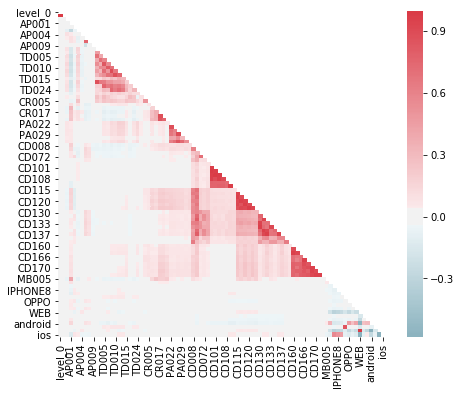

In [36]:
fig = plt.figure(figsize=(8,6))
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and caorrect aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True)
plt.show()

In [37]:
def corr_based_feature_select(dat, threshold):
    """
    Remove columns that do exceeed correlation threshold
    """
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dat.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dat.columns:
                    del dat[colname] # deleting the column from the dataset
    return dat

In [38]:
df= corr_based_feature_select(df,0.8)
df.shape

(76693, 55)

In [39]:
# now combining the name from the dictionary data!
var_dict = pd.read_csv('data/Variables_Dictionary_2019.zip')
var_dict = var_dict[var_dict['Var'].isin(df.columns)]

#var_dict

new_dict = {} 
for val in range(0,len(var_dict)): 
    new_dict[var_dict.iloc[val,1]] = var_dict.iloc[val,3]
#print(new_dict)

new_column_name = []

for col in df.columns:
    try: 
        new_column_name.append(new_dict[col]) 
    except KeyError:
        new_column_name.append(col)
        
df.columns = new_column_name

In [40]:
df.head()

,level_0,loan_default,YR_AGE,CODE_GENDER,CODE_EDUCATION,LOAN_TERM,LEVEL_APPL_CITY,FLAG_IP_CITY_NOT_APPL_CITY,AP009,TD_CNT_QUERY_LAST_7Day_P2P,...,IPHONE9,Noinfo,OPPO,SAMSUNG,VIVO,WEB,XIAOMI,others,android,ios
0,0,1,31,2,1,12,3,3,1,1,...,0,0,0,0,0,0,0,0,0,1
1,1,0,33,1,4,12,4,2,0,2,...,0,0,0,0,0,1,0,0,0,0
2,2,0,34,2,4,12,5,5,0,0,...,0,0,1,0,0,0,0,0,1,0
3,3,1,32,1,1,12,5,4,0,2,...,0,0,0,0,0,1,0,0,0,0
4,4,1,23,1,3,12,1,1,0,2,...,0,0,0,0,0,0,0,0,0,1


Use RF feature importance to select features:

In [41]:
target = 'loan_default'
predictors = df.columns[2:]

In [42]:
from sklearn.model_selection import train_test_split

y = df[target]
x = df[predictors]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=42)

In [43]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [44]:
rf_feature_importance = pd.DataFrame({'Name': x_train.columns,
             'Feature Importances': rf.feature_importances_})
rf_feature_importance = rf_feature_importance.sort_values(by = 'Feature Importances',ascending=False).reset_index()
rf_feature_importance = rf_feature_importance.drop(columns='index')

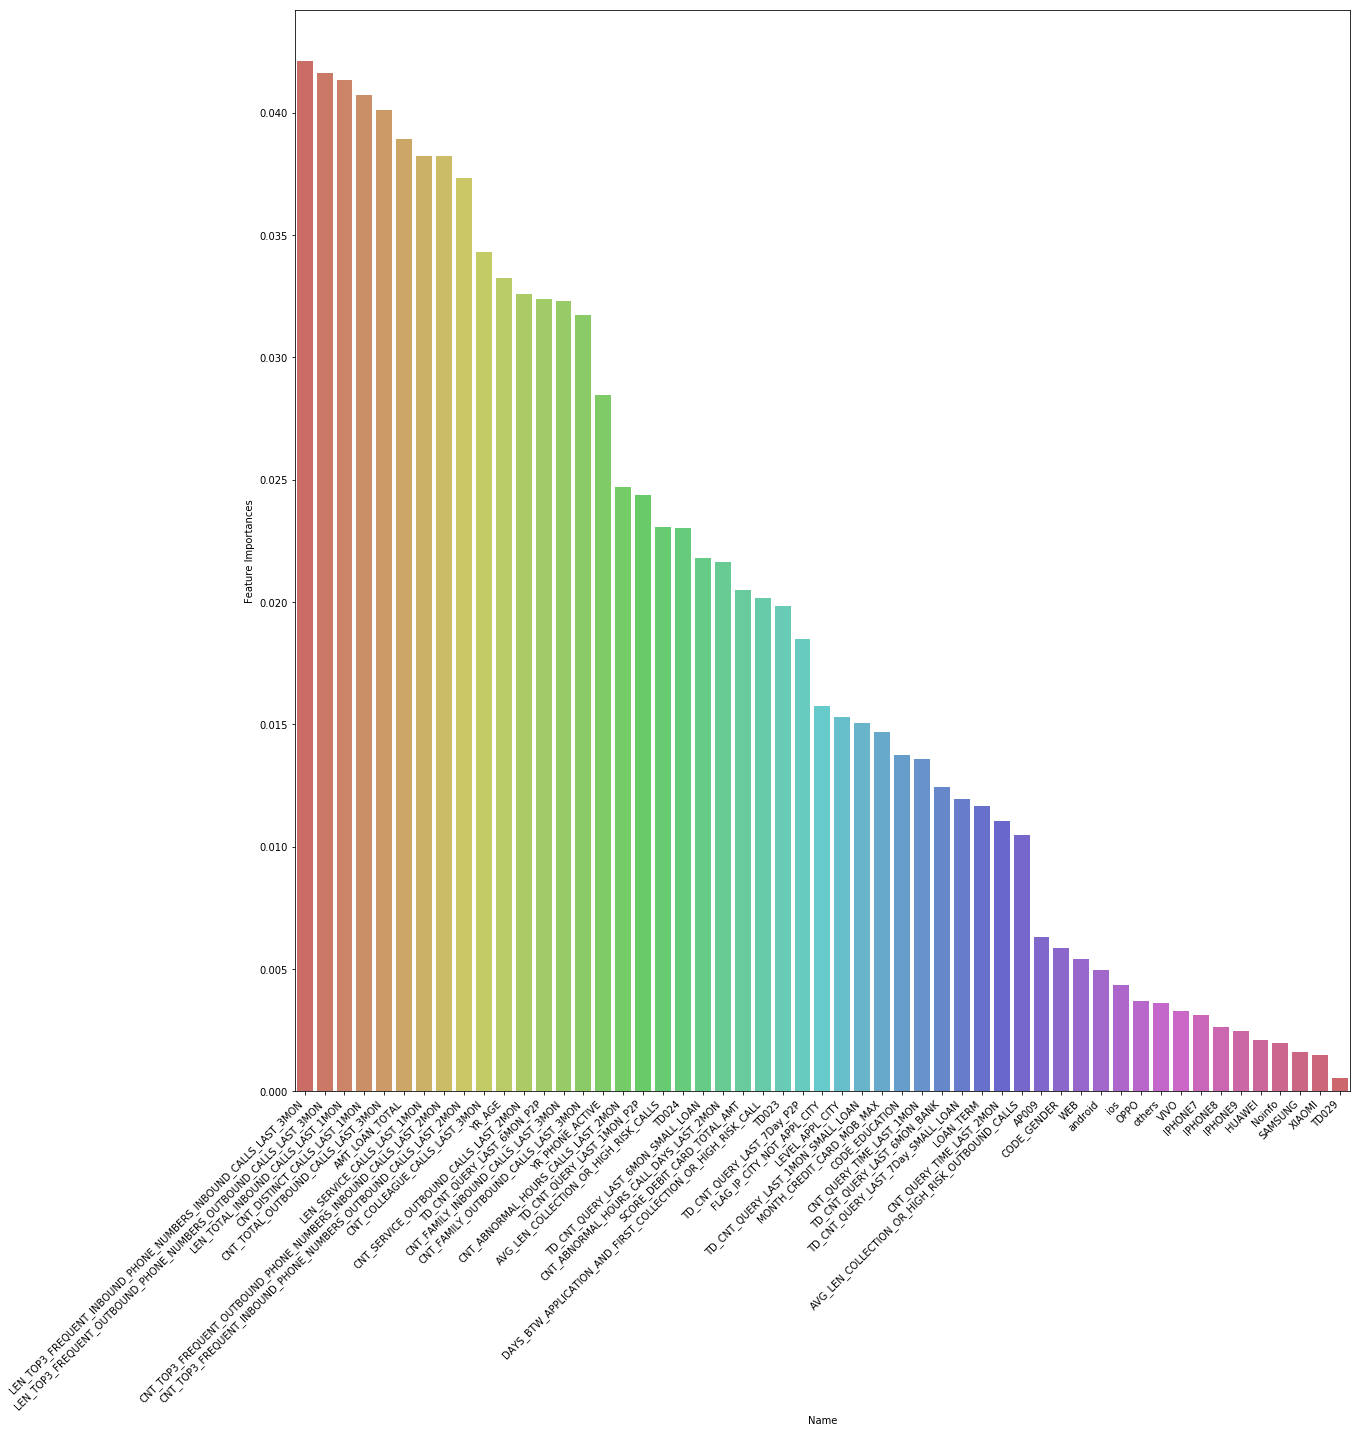

In [45]:
fig = plt.figure(figsize=(19,20))
pp=sns.barplot(x ='Name', y = 'Feature Importances', data=rf_feature_importance, palette = 'hls')
pp.set_xticklabels(pp.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()

In [46]:
rf_feature_importance['cum_sum'] = rf_feature_importance['Feature Importances'].cumsum()
rf_feature_importance

,Name,Feature Importances,cum_sum
0,LEN_TOP3_FREQUENT_INBOUND_PHONE_NUMBERS_INBOUN...,0.042094,0.042094
1,LEN_TOP3_FREQUENT_OUTBOUND_PHONE_NUMBERS_OUTBO...,0.041613,0.083706
2,LEN_TOTAL_INBOUND_CALLS_LAST_1MON,0.041345,0.125051
3,CNT_DISTINCT_CALLS_LAST_1MON,0.040702,0.165753
4,CNT_TOTAL_OUTBOUND_CALLS_LAST_3MON,0.040126,0.205879
5,AMT_LOAN_TOTAL,0.038939,0.244818
6,LEN_SERVICE_CALLS_LAST_1MON,0.038238,0.283056
7,CNT_TOP3_FREQUENT_OUTBOUND_PHONE_NUMBERS_INBOU...,0.038221,0.321277
8,CNT_TOP3_FREQUENT_INBOUND_PHONE_NUMBERS_OUTBOU...,0.037331,0.358608
9,CNT_COLLEAGUE_CALLS_LAST_3MON,0.034312,0.392920


Using the random forest important feauture i found that the top 32 features contirubutes to 90% of prediction value

In [47]:
rf_feature_importance[33:]['Name'].values
clean_df = df.drop(columns=rf_feature_importance[33:]['Name'].values)

In [48]:
clean_df.head()

,level_0,loan_default,YR_AGE,CODE_EDUCATION,LEVEL_APPL_CITY,FLAG_IP_CITY_NOT_APPL_CITY,TD_CNT_QUERY_LAST_7Day_P2P,TD_CNT_QUERY_LAST_1MON_P2P,TD_CNT_QUERY_LAST_1MON_SMALL_LOAN,TD_CNT_QUERY_LAST_6MON_P2P,...,CNT_ABNORMAL_HOURS_CALLS_LAST_2MON,CNT_ABNORMAL_HOURS_CALL_DAYS_LAST_2MON,CNT_DISTINCT_CALLS_LAST_1MON,CNT_TOP3_FREQUENT_OUTBOUND_PHONE_NUMBERS_INBOUND_CALLS_LAST_2MON,CNT_TOP3_FREQUENT_INBOUND_PHONE_NUMBERS_OUTBOUND_CALLS_LAST_2MON,LEN_TOP3_FREQUENT_OUTBOUND_PHONE_NUMBERS_OUTBOUND_CALLS_LAST_3MON,LEN_TOP3_FREQUENT_INBOUND_PHONE_NUMBERS_INBOUND_CALLS_LAST_3MON,CNT_SERVICE_OUTBOUND_CALLS_LAST_2MON,LEN_SERVICE_CALLS_LAST_1MON,YR_PHONE_ACTIVE
0,0,1,31,1,3,3,1,4,1,14,...,0.0,0.0,57.0,43.0,55.0,10900.0,12757.0,8.0,0.0,7.0
1,1,0,33,4,4,2,2,4,1,9,...,0.0,0.0,13.0,11.0,9.0,3807.0,2314.0,0.0,33.0,8.0
2,2,0,34,4,5,5,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0
3,3,1,32,1,5,4,2,5,2,6,...,4.0,2.0,30.0,68.0,36.0,3066.0,22641.0,6.0,563.0,5.0
4,4,1,23,3,1,1,2,2,0,2,...,1.0,1.0,5.0,5.0,3.0,3347.0,528.0,4.0,995.0,1.0


In [58]:
target = 'loan_default'
predictors = clean_df.columns[2:]
y = clean_df[target]
x = clean_df[predictors]
## shap takes tooo long to run so i will minimize the val size 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.002,random_state=42)

USING SHAP Random Forest

In [50]:
#!pip install shap

  Using cached https://files.pythonhosted.org/packages/a8/77/b504e43e21a2ba543a1ac4696718beb500cfa708af2fb57cb54ce299045c/shap-0.35.0.tar.gz
  Stored in directory: C:\Users\caffr\AppData\Local\pip\Cache\wheels\e7\f7\0f\b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


In [59]:
rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [60]:
import shap
shap.initjs()
rf_explainer = shap.KernelExplainer(rf.predict, x_val)

Using 154 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [61]:
rf_shap_values = rf_explainer.shap_values(x_val)

# plot the SHAP values for the 10th observation 
shap.force_plot(rf_explainer.expected_value, rf_shap_values[10,:], x_val.iloc[10,:]) 

In [62]:
shap.force_plot(rf_explainer.expected_value, rf_shap_values[6,:], x_val.iloc[10,:]) 

In [63]:
# plot the SHAP values for the 10th observation 
shap.force_plot(rf_explainer.expected_value, rf_shap_values[0,:], x_val.iloc[10,:]) 

In [65]:
# plot the SHAP values for the 10th observation 
shap.force_plot(rf_explainer.expected_value, rf_shap_values[20,:], x_val.iloc[10,:]) 

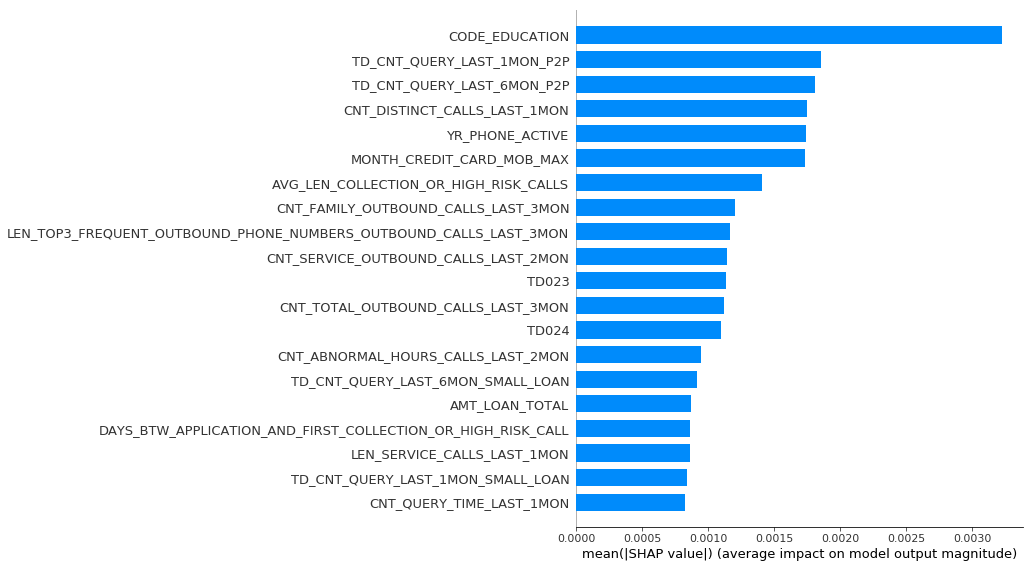

In [66]:
shap.summary_plot(rf_shap_values, x_test, plot_type="bar")

In [68]:
shap.force_plot(rf_explainer.expected_value, rf_shap_values, x_test)

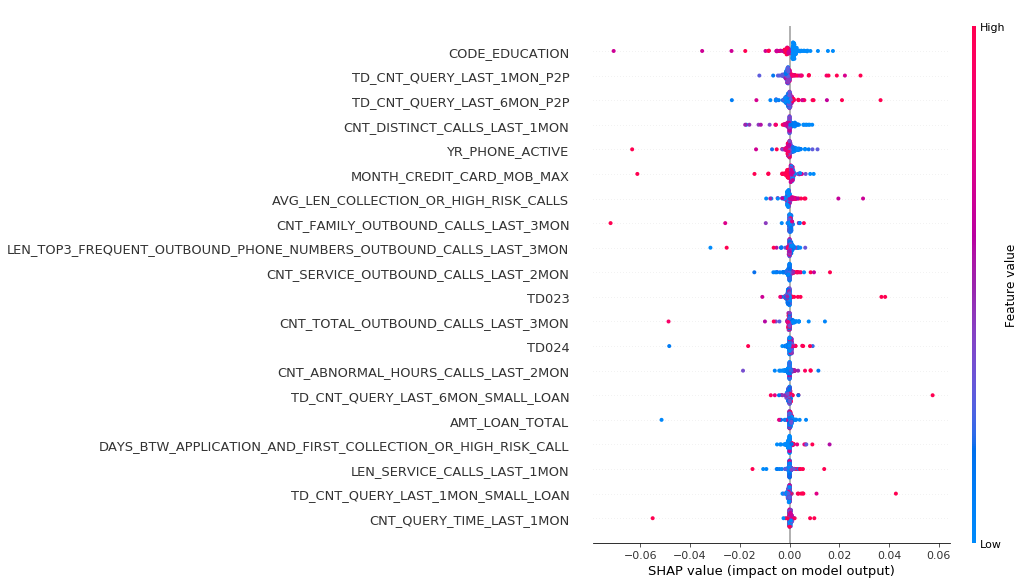

In [69]:
shap.summary_plot(rf_shap_values, x_val)

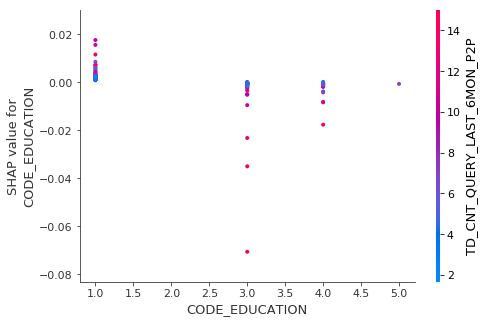

In [70]:
shap.dependence_plot('CODE_EDUCATION',rf_shap_values, x_val)

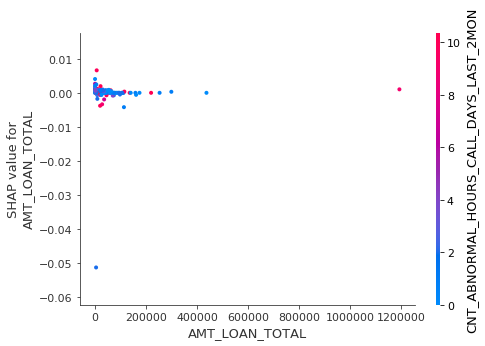

In [71]:
shap.dependence_plot('AMT_LOAN_TOTAL',rf_shap_values, x_val)

Ada Boost

In [77]:
from sklearn.ensemble import AdaBoostClassifier

n_estimators = 500
#ada = AdaBoostClassifier() #ada is not callable! :) new thing to learn
ada = AdaBoostClassifier(n_estimators=n_estimators,
          random_state=42)
ada.fit(x_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=500, random_state=42)

In [79]:
ada_explainer = shap.KernelExplainer(ada.predict, x_val)
ada_shap_values = ada_explainer.shap_values(x_val)

Using 154 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [80]:
shap.force_plot(ada_explainer.expected_value, ada_shap_values[12,:], x_val.iloc[12,:]) 

In [81]:
shap.force_plot(ada_explainer.expected_value, ada_shap_values[21,:], x_val.iloc[21,:]) 

In [82]:
shap.force_plot(ada_explainer.expected_value, ada_shap_values[17,:], x_val.iloc[17,:]) 

In [83]:
shap.force_plot(ada_explainer.expected_value, ada_shap_values[15,:], x_val.iloc[15,:]) 

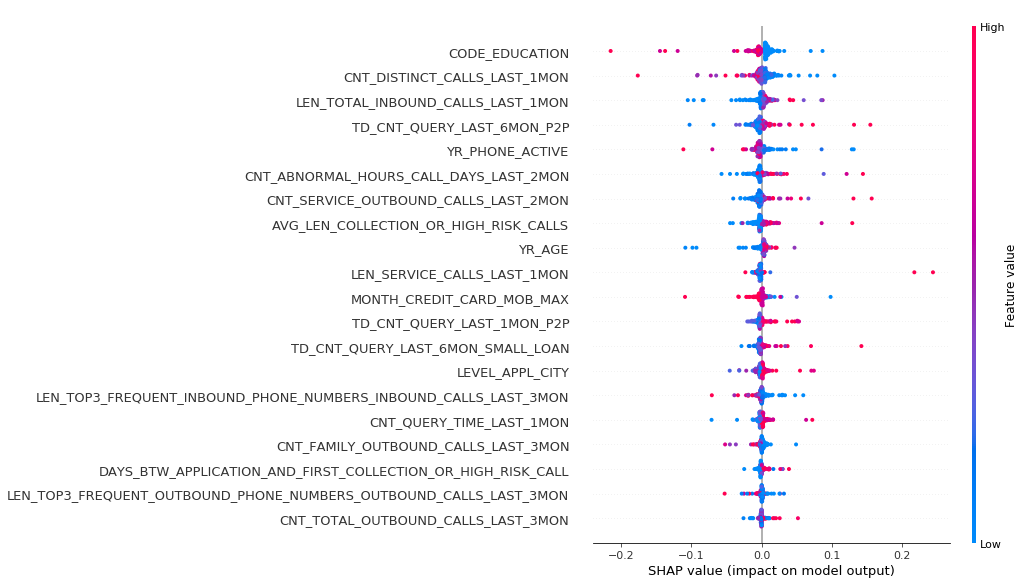

In [84]:
shap.summary_plot(ada_shap_values, x_val)


Summary:

Education: The most important variable to predict the default risk of the customer. The model can be interpreted that the higher education, the lower the risk of default. I’m not assuming that people with higher education care more about their credit, nor that people with lower education are unconscious about paying their bill on time, but rather that education is a sign of affordability, and the ability to earn a higher income. I’m assuming that there’s a confounding variable not present in the model, income, and Education is highly correlated with that variable. The graph shows a clear divide between best in class credit vs. high default risk.


In [85]:
shap.force_plot(ada_explainer.expected_value, ada_shap_values, x_test)

In [86]:
shap.force_plot(ada_explainer.expected_value, ada_shap_values, x_test)

In [87]:
shap.force_plot(ada_explainer.expected_value, ada_shap_values[6,:], x_val.iloc[6,:]) 

In [88]:
yr_age = clean_df[['YR_AGE','YR_PHONE_ACTIVE']]
yr_age.corr()

,YR_AGE,YR_PHONE_ACTIVE
YR_AGE,1.000000,0.412414
YR_PHONE_ACTIVE,0.412414,1.000000




YEAR_PHONE_ACTIVE: The model is indicating that the user who has a phone activated for fewer years are a higher credit risk. Typically in the US, a cell phone is the first credit item someone receives to built credit history. This variable may indicate that people with a short credit history are at a higher risk of default. However, it’s not a strong indicator highlighted by the graph below.

In a few samples that I’ve evaluated the relative impact on the default is benign compared to other variables.


In [89]:
shap.force_plot(ada_explainer.expected_value, ada_shap_values, x_test)



Example illustrates the impact of a user with phone active of 3 years.




In [ ]:
shap.force_plot(ada_explainer.expected_value, ada_shap_values[58,:], x_val.iloc[58,:]) 



AVG_ION_OR_HIGH_RISK_CALLS:

On average, negative High-Risk Call is benign; however a low call can reduce the risk probability dramatically. There's not enought information given to poperly conduct an anlaysis on what this variable measures.


In [ ]:
shap.force_plot(ada_explainer.expected_value, ada_shap_values, x_test)

Monthly Credit Card Max : SHAP value indicates that users with a high monthly credit card max, have a higher probability of default compared to those with lower max. User with a high credit card utilization is not likely maximizing credit cards by choice. Perhaps the individuals' monthly expenses exceed their income, and they compensate by borrowing against their credit to meet their monthly expenses.

In [ ]:
shap.force_plot(ada_explainer.expected_value, ada_shap_values, x_test)

In [ ]:
shap.force_plot(ada_explainer.expected_value, ada_shap_values[12,:], x_val.iloc[12,:]) 


Conclusion:

The SHAP value can be useful in demystifying the decision-drivers of complex models such as Random Forest and Boosting models. Based on my observation, the same variable can have a positive impact on one user and a negative impact on another user. Also, the model is capturing relationships not present in the data, such as income and credit history length.

    Would love to see how income, and credit length history impact the mode.




Reference

Interpreting complex models with SHAP values
Explain Any Models with the SHAP Values — Use the KernelExplainer
Shap
A Unified Approach to Interpreting Model Predictions
Demystifying Black-Box Models with SHAP Value Analysis
https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d
